# Fitting the continuum flux of astronomical spectra

## Original data can be obtained from:  
### http://james.as.arizona.edu/~psmith/Fermi/DATA/individual.html  


## Science Goals:
### Explore some spectropolarimetry data (spectrum and polarized flux spectrum) of a $\gamma-$ray bright blazar and determine if the variability in emission is dominated by the accretion disk (non-polarized component) or the jet (polarized component).

###  1) Import flux spectra and polarized flux spectra from the FITS files they are contained in

In [1]:
import pandas as pd
direc = './spectra'
from spectra_df import spectra_df
fspec, pspec = spectra_df(direc)

## Plotting the original spectrum and the polarized flux spectrum informs the decision for the type of model to use.
### The physics suggest a linear combination of power-laws
### $F_{\nu} = A \nu^{-\alpha} + B \nu^{-\beta}$

<IPython.core.display.Javascript object>


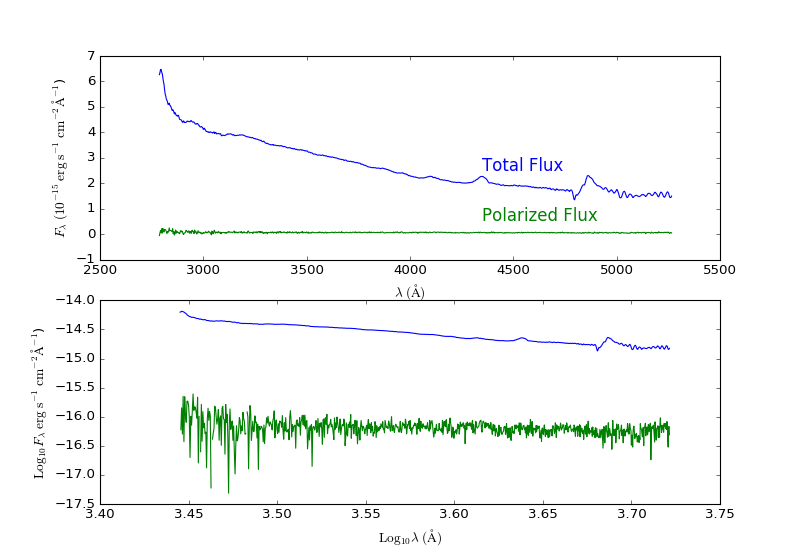

In [2]:
from plot_fig_one import plot_fig_one
%matplotlib nbagg
plot_fig_one(fspec, pspec, 7)

## 2) Emission lines must be removed before we can fit the continuum
### This is accomplished by using a template generated from another spectrum of the same object that covers a higher range of frequencies.

<IPython.core.display.Javascript object>


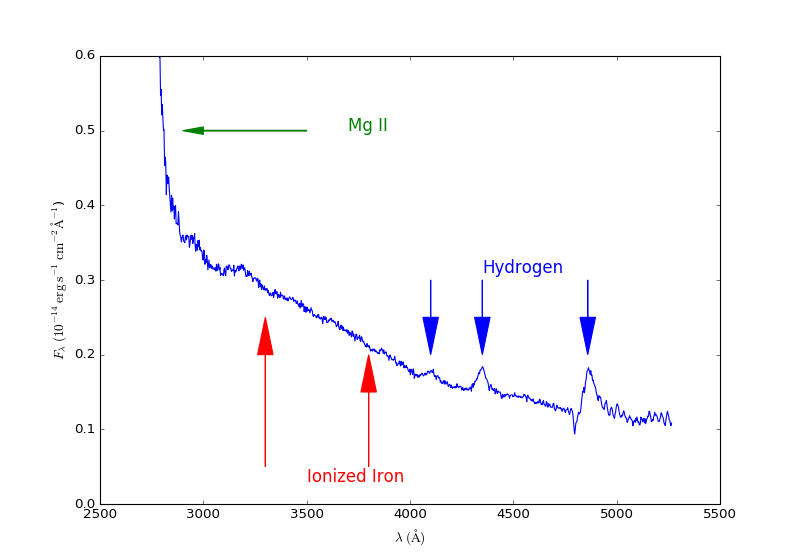

In [3]:
from plot_spectrum import plot_spectrum
plot_spectrum(fspec, pspec,1)

<IPython.core.display.Javascript object>


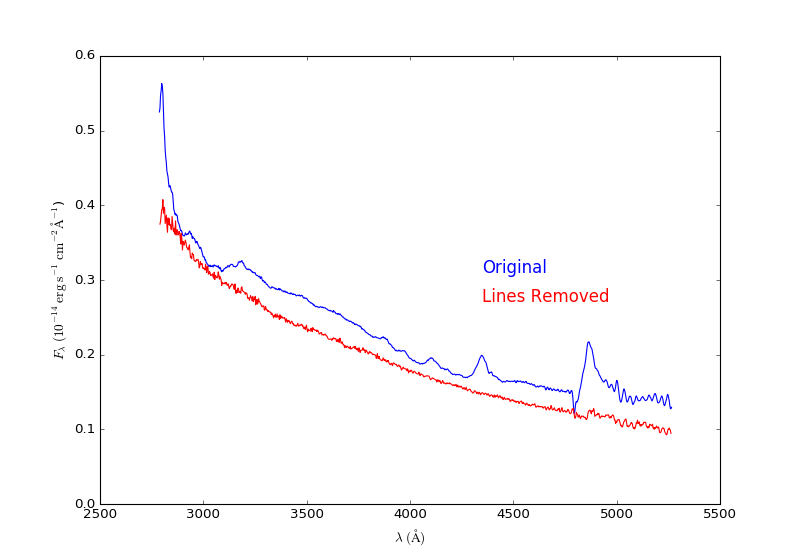

In [4]:
import numpy as np
from remove_template import remove_template
from plot_spectrum_linesrm import plot_spectrum_linesrm 
spec = fspec
template, newframe = remove_template('template.txt', fspec)
plot_spectrum_linesrm(fspec, newframe, 15)

### All of the spectra animated

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

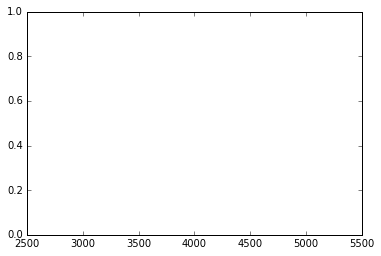

In [6]:
fig, ax = plt.subplots()

ax.set_xlim(( 2500, 5500))
ax.set_ylim((0, 1.0))

line, = ax.plot([], [], lw=2)

In [7]:
def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = newframe['wl']
    ynorm = 1.0e-14
    y = newframe[newframe.columns[i]]/ynorm
    line.set_data(x, y)
    ax.set_ylabel(r'$F_\lambda \; (10^{'+str(np.trunc(np.log10(ynorm)).astype(int)) +r'} \; \mathrm{erg \; s}^{-1}\;\mathrm{cm}^{-2}\mathrm{\AA}^{-1}$)')
    ax.set_xlabel(r'$\lambda \;(\mathrm{\AA})$')
    ax.set_title(fspec.columns.values[i])
    return (line,)


In [8]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=51, interval=200, blit=True)

HTML(anim.to_html5_video())


## 3) Fit a power-law to the flux spectrum and polarized flux spectrum
### $F_{\lambda} = A \lambda^{-\alpha}$

In [9]:
import lmfit
from lmfit import  Model, minimize, Parameters
from find_plaw_resid import find_plaw_resid
import numpy as np
from fit_power_law import fit_power_law


/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [10]:
fluxplaw_params = fit_power_law(newframe, 13)
print fluxplaw_params['alpha'].value
polplaw_params = fit_power_law(pspec, 13)
print polplaw_params['alpha'].value


1.59618518278
0.584950439172


## 4) Is a multi-component model justified?

<IPython.core.display.Javascript object>


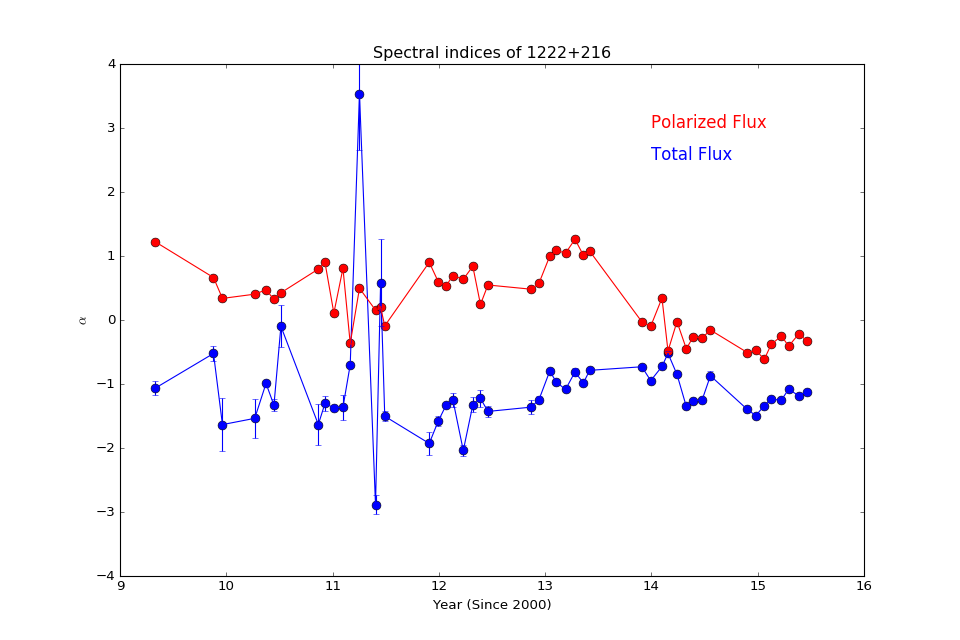

In [11]:
%matplotlib nbagg
indices = pd.read_csv('alphaoutput.csv')
models = pd.read_csv('spectral_component_flux.csv')
models['total'] = models['bbbmodel'] + models['synmodel'] + models['bbodymodel']
thermcol = models['bbbmodel']+models['bbodymodel']
models= models.assign(total_thermal=thermcol)

from astropy.time import Time as tm
t = tm(indices['MJD'], format= 'mjd')
fig = plt.figure(4, figsize=(12,8))
plt.plot(t.byear-2000, indices['alpha_flux']*(-1), marker='o', color = 'blue', 
         markersize=8, linestyle = '')
plt.plot(t.byear-2000, indices['alpha_pol']* (-1), marker='o', color = 'red', 
         markersize=8, linestyle = '')
plt.ylim((-4,4));
plt.xlim((9, 16));
plt.errorbar(t.byear-2000, indices['alpha_flux']* (-1),indices['sigma'], color = 'blue')
plt.errorbar(t.byear-2000, indices['alpha_pol']* (-1),indices['sigma_alpha_pol'], color = 'red')
plt.xlabel('Year (Since 2000)')
plt.ylabel(r'$\alpha$')
plt.text(14, 3, 'Polarized Flux', color='red', fontsize=15)
plt.text(14, 2.5, 'Total Flux', color='blue', fontsize=15)
plt.title('Spectral indices of 1222+216')


<IPython.core.display.Javascript object>


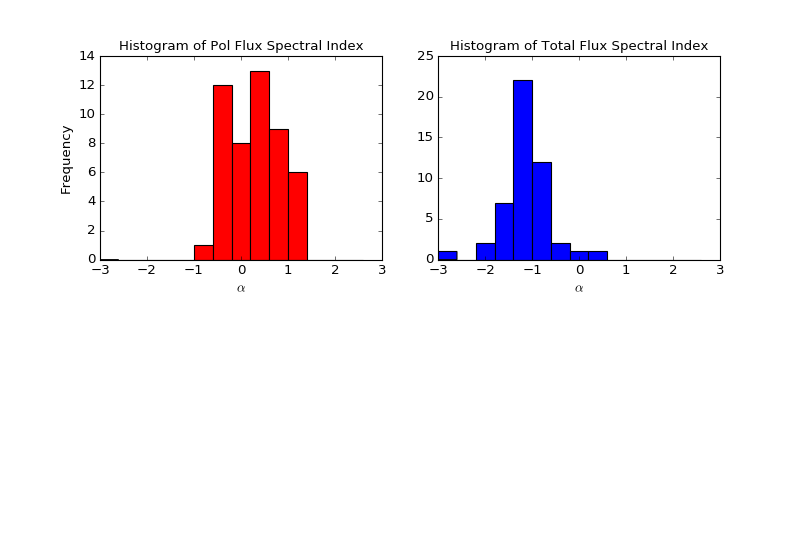

In [12]:
%matplotlib nbagg

fig = plt.figure(5, figsize=(10,7))
ax1 = plt.subplot(221)
ax1.hist(indices['alpha_pol']* (-1),bins=np.arange(-3, 3, 0.4) ,color = 'red')
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Pol Flux Spectral Index', fontsize=12)
ax2 = plt.subplot(222)
ax2.hist(indices['alpha_flux']* (-1), bins=np.arange(-3, 3, 0.4), color = 'blue')
ax2.set_title('Histogram of Total Flux Spectral Index', fontsize=12)
ax2.set_xlabel(r'$\alpha$')



## 5) Results
### Paramaterize the variability of each of the components by $\frac{\sigma_{x}}{\langle F_{Total}\rangle}$

In [13]:
indices = pd.read_csv('alphaoutput.csv')
models = pd.read_csv('spectral_component_flux.csv')
models['total'] = models['bbbmodel'] + models['synmodel'] + models['bbodymodel']
thermcol = models['bbbmodel']+models['bbodymodel']
models= models.assign(total_thermal=thermcol)
thermal_variation =models['total_thermal'].std()/models['total'].mean()
synchrotron_variation= models['synmodel'].std()/models['total'].mean()
print thermal_variation, synchrotron_variation

0.102232824893 0.513095740591


<IPython.core.display.Javascript object>


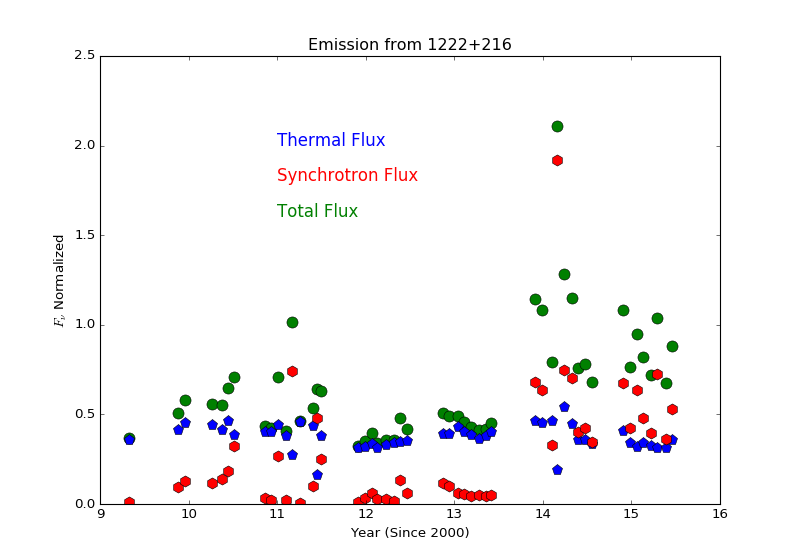

In [15]:
%matplotlib nbagg
import matplotlib.pyplot as plt
from astropy.time import Time as tm
t = tm(models['mjdarr'], format= 'mjd')
fig = plt.figure(6, figsize=(10,7))
normal = 1.0e-11
plt.plot(t.byear-2000.0, models['total']/normal, marker='o', color = 'green', 
         markersize=10, linestyle = '')
plt.plot(t.byear-2000.0, models['total_thermal']/normal, marker='p', color = 'blue', 
         markersize=10, linestyle = '')
plt.plot(t.byear-2000.0, models['synmodel']/normal, marker='h', color = 'red', 
         markersize=10, linestyle = '')
#plt.plot(indices['MJD'], indices['alpha_pol']* (-1), marker='o', color = 'red', 
   #      markersize=5, linestyle = '')
plt.ylim((0,2.5));
plt.xlabel('Year (Since 2000)')
plt.ylabel(r'$F_{\nu}$ Normalized')
plt.text(11, 2, 'Thermal Flux', color='blue', fontsize=15)
plt.text(11, 1.8, 'Synchrotron Flux', color='red', fontsize=15)
plt.text(11, 1.6, 'Total Flux', color='green', fontsize=15)
plt.title('Emission from 1222+216')
